In [1]:
cd ..

/Users/alex/git/auspatious/dea-coastlines


In [2]:
%matplotlib inline
# %load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import geopandas as gpd
from datacube.utils.geometry import Geometry

from collections import Counter

# Load DEA Coastlines and DEA tools code
import coastlines.raster
import coastlines.utils
from datacube.utils.dask import start_local_dask
from dea_tools.coastal import pixel_tides

from odc.algo import mask_cleanup
from odc.stac import configure_s3_access

# Create local dask client for parallelisation
dask_client = start_local_dask(n_workers=4, threads_per_worker=4, memory_limit="12GB")

# Configure S3 access including request payer
# os.environ["AWS_REQUEST_PAYER"]='requester'
_ = configure_s3_access(profile="alex-read-s3", requester_pays=True, cloud_defaults=True)

## Setup


### Set analysis parameters

In [3]:
study_area = "13,45"
study_area = "9,19"
raster_version = 'testing'
YEAR = 2020
config_path = 'configs/vietnam_coastlines_config_development.yaml'

# Load analysis params from config file
config = coastlines.utils.load_config(
    config_path=config_path)

### Load supplementary data

<Axes: >

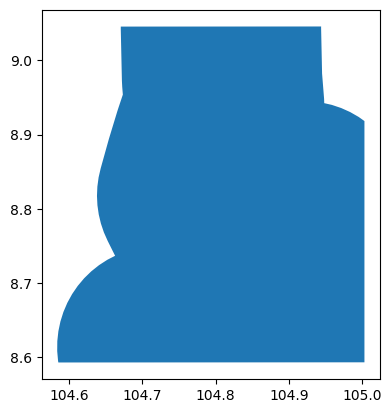

In [4]:
# Albers grid cells used to process the analysis
gridcell_gdf = (
    gpd.read_file(config['Input files']['grid_path']).to_crs(
        epsg=4326).set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]
gridcell_gdf.plot()

In [31]:
# Load MNDWI from STAC
from odc.stac import load
from pystac_client import Client

os.environ['AWS_REQUEST_PAYER'] = 'requester'
usgs_url = "https://landsatlook.usgs.gov/stac-server"
client = Client.open(usgs_url)
collections = ["landsat-c2l2-sr"]
query = {"platform":{"in": ["LANDSAT_8", "LANDSAT_9"]}}

def http_to_s3_url(http_url):
    """Convert a USGS HTTP URL to an S3 URL"""
    s3_url = http_url.replace('https://landsatlook.usgs.gov/data', 's3://usgs-landsat').rstrip(":1")
    return s3_url

# Create query based on analysis gridcell extent
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
bbox = geopoly.buffer(0.05).boundingbox
query = {
    "bbox": [bbox.left, bbox.bottom, bbox.right, bbox.top],
    "datetime": f"{YEAR}",
    "query": query,
}

items = list(client.search(collections=collections, **query).get_all_items())

print(f"Found {len(items)} items")

Found 68 items


In [37]:
for name, asset in items[6].assets.items():
    print(f"{name}: {asset.href}")


thumbnail: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2020/126/054/LC08_L2SP_126054_20201128_20210316_02_T1/LC08_L2SP_126054_20201128_20210316_02_T1_thumb_small.jpeg
reduced_resolution_browse: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2020/126/054/LC08_L2SP_126054_20201128_20210316_02_T1/LC08_L2SP_126054_20201128_20210316_02_T1_thumb_large.jpeg
index: https://landsatlook.usgs.gov/stac-browser/collection02/level-2/standard/oli-tirs/2020/126/054/LC08_L2SP_126054_20201128_20210316_02_T1/LC08_L2SP_126054_20201128_20210316_02_T1
MTL.json: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2020/126/054/LC08_L2SP_126054_20201128_20210316_02_T1/LC08_L2SP_126054_20201128_20210316_02_T1_MTL.json
coastal: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2020/126/054/LC08_L2SP_126054_20201128_20210316_02_T1/LC08_L2SP_126054_20201128_20210316_02_T1_SR_B1.TIF
blue: https://landsatlook.usgs.gov/

In [7]:
epsg_codes = Counter(item.properties["proj:epsg"] for item in items)
most_common_epsg = epsg_codes.most_common(1)[0][0]

In [10]:
cfg = {
    "landsat-c2l2-sr": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
        }
    },
    "*": {"warnings": "ignore"},
}

ds = load(
    items,
    bands=["red", "green", "blue", "nir08", "swir16", "swir22", "coastal", "qa_pixel"],
    **query,
    crs=most_common_epsg,
    resolution=30,
    stac_cfg=cfg,
    chunks={"x": 2000, "y": 2000, "time": 1},
    group_by="solar_day",
    patch_url=http_to_s3_url
)

# Mask where there is no data
ds = ds.where(ds.green != 0)

for band in ["red", "green", "blue", "nir08", "swir16", "swir22", "coastal"]:
    ds[band] = ds[band].astype("float32") * 0.0000275 + -0.2

# ds["mndwi"] = (ds.green - ds.swir22) / (ds.green + ds.swir22)

# Get cloud and cloud shadow mask
# Example here https://stackstac.readthedocs.io/en/v0.3.0/examples/gif.html
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

# Get cloud mask
cloud_mask = ds["qa_pixel"].astype(int) & bitmask != 0

# Expand and contract the mask to clean it up
dilated = mask_cleanup(cloud_mask, [("opening", 2), ("dilation", 3)])

ds = ds.where(~dilated)

ds

<xarray.Dataset>
Dimensions:      (time: 114, y: 2038, x: 1903)
Coordinates:
  * y            (y) float64 1.005e+06 1.005e+06 ... 9.444e+05 9.444e+05
  * x            (x) float64 4.487e+05 4.488e+05 ... 5.058e+05 5.058e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2020-01-05T03:01:30.220219 ... 2020-12...
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    nir08        (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    swir16       (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    coastal      (time, y, x) float32 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>
    qa_pixel     (time, y, x) float64 dask.array<chunksize=(1, 2000, 1903), meta=np.ndarray>

In [11]:
one_year = ds.sel(time="2020").median(dim="time")
one_year

<xarray.Dataset>
Dimensions:      (y: 2038, x: 1903)
Coordinates:
  * y            (y) float64 1.005e+06 1.005e+06 ... 9.444e+05 9.444e+05
  * x            (x) float64 4.487e+05 4.488e+05 ... 5.058e+05 5.058e+05
    spatial_ref  int32 32648
Data variables:
    red          (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    green        (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    blue         (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    nir08        (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    swir16       (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    swir22       (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    coastal      (y, x) float32 dask.array<chunksize=(396, 742), meta=np.ndarray>
    qa_pixel     (y, x) float64 dask.array<chunksize=(280, 524), meta=np.ndarray>

In [10]:
for band in ["red", "green", "blue", "nir08", "swir16", "swir22", "coastal"]:
    one_year[band].odc.write_cog(f"{band}.tif", overwrite=True)

In [12]:
ds["mndwi"] = (ds.green - ds.swir16) / (ds.green + ds.swir16)
ds.mndwi.median(dim="time").odc.write_cog("mndwi_pre.tif", overwrite=True)

PosixPath('mndwi_pre.tif')

In [13]:
mndwi_post = (one_year.green - one_year.swir16) / (one_year.green + one_year.swir16)
mndwi_post.odc.write_cog("mndwi_post.tif", overwrite=True)

PosixPath('mndwi_post.tif')

In [14]:
ds["ndwi"] = (ds.green - ds.nir08) / (ds.green + ds.nir08)
ds.ndwi.median(dim="time").odc.write_cog("ndwi_pre.tif", overwrite=True)

PosixPath('nir_ratio_pre.tif')

In [12]:
ds["awei"] = 4 * (ds.green - ds.swir22) - (0.25 * ds.nir08 + 2.75 * ds.swir16)
ds.awei.median(dim="time").odc.write_cog("awei_pre.tif", overwrite=True)

PosixPath('awei_pre.tif')

In [14]:
count = ds.green.count(dim="time")
count.astype("uint8").odc.write_cog("count.tif", overwrite=True)

PosixPath('count.tif')

In [47]:
# Load some data from ESA's land cover
from planetary_computer import sign

pc_url = "https://planetarycomputer.microsoft.com/api/stac/v1/"

pc_client = Client.open(pc_url)
items = sign(pc_client.search(collections=["esa-cci-lc"], bbox=bbox, datetime=f"{YEAR}").get_all_items())
print(len(items))

landcover = load(sign(items), bbox=bbox, chunks={}, crs=most_common_epsg, resolution=30)
landcover

1


<xarray.Dataset>
Dimensions:              (y: 2038, x: 1903, time: 1)
Coordinates:
  * y                    (y) float64 1.005e+06 1.005e+06 ... 9.444e+05 9.444e+05
  * x                    (x) float64 4.487e+05 4.488e+05 ... 5.058e+05 5.058e+05
    spatial_ref          int32 32648
  * time                 (time) datetime64[ns] 2020-01-01
Data variables:
    lccs_class           (time, y, x) uint8 dask.array<chunksize=(1, 2038, 1903), meta=np.ndarray>
    change_count         (time, y, x) uint8 dask.array<chunksize=(1, 2038, 1903), meta=np.ndarray>
    processed_flag       (time, y, x) uint8 dask.array<chunksize=(1, 2038, 1903), meta=np.ndarray>
    observation_count    (time, y, x) uint16 dask.array<chunksize=(1, 2038, 1903), meta=np.ndarray>
    current_pixel_state  (time, y, x) uint8 dask.array<chunksize=(1, 2038, 1903), meta=np.ndarray>

In [94]:
# Load some data from ESA's land cover
from planetary_computer import sign

pc_url = "https://planetarycomputer.microsoft.com/api/stac/v1/"

pc_client = Client.open(pc_url)
items = sign(pc_client.search(collections=["esa-worldcover"], bbox=bbox, datetime=f"{YEAR}").get_all_items())
print(len(items))

landcover = load(sign(items), bbox=bbox, chunks={}, crs=most_common_epsg, resolution=30)
landcover

4


<xarray.Dataset>
Dimensions:          (y: 2042, x: 1907, time: 1)
Coordinates:
  * y                (y) float64 1.006e+06 1.005e+06 ... 9.443e+05 9.443e+05
  * x                (x) float64 4.486e+05 4.487e+05 ... 5.058e+05 5.058e+05
    spatial_ref      int32 32648
  * time             (time) datetime64[ns] 2020-01-01
Data variables:
    map              (time, y, x) uint8 dask.array<chunksize=(1, 2042, 1907), meta=np.ndarray>
    input_quality.1  (time, y, x) int16 dask.array<chunksize=(1, 2042, 1907), meta=np.ndarray>
    input_quality.2  (time, y, x) int16 dask.array<chunksize=(1, 2042, 1907), meta=np.ndarray>
    input_quality.3  (time, y, x) int16 dask.array<chunksize=(1, 2042, 1907), meta=np.ndarray>

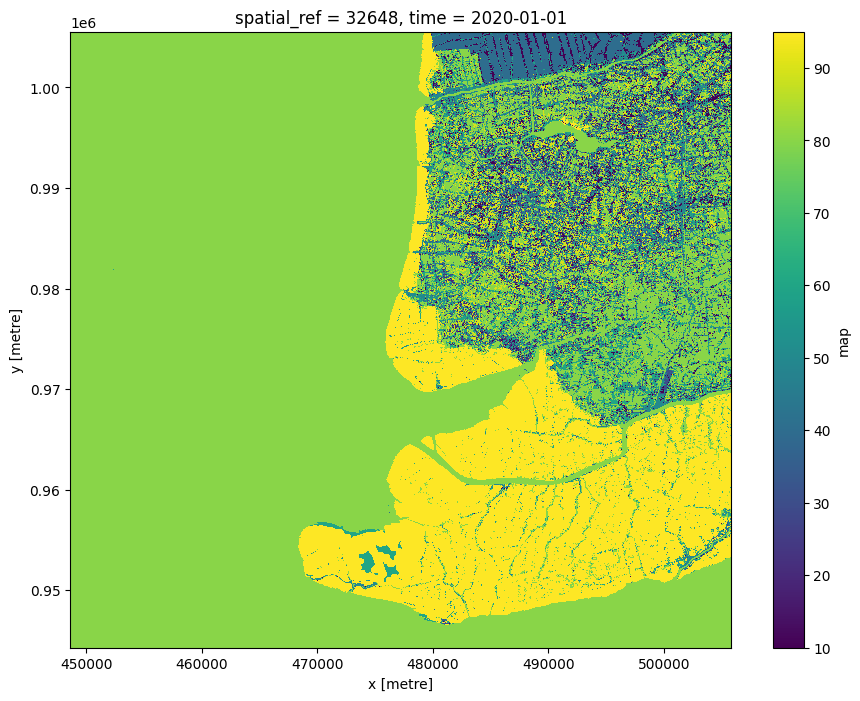

In [95]:
landcover["map"].isel(time=0).plot(size=8)

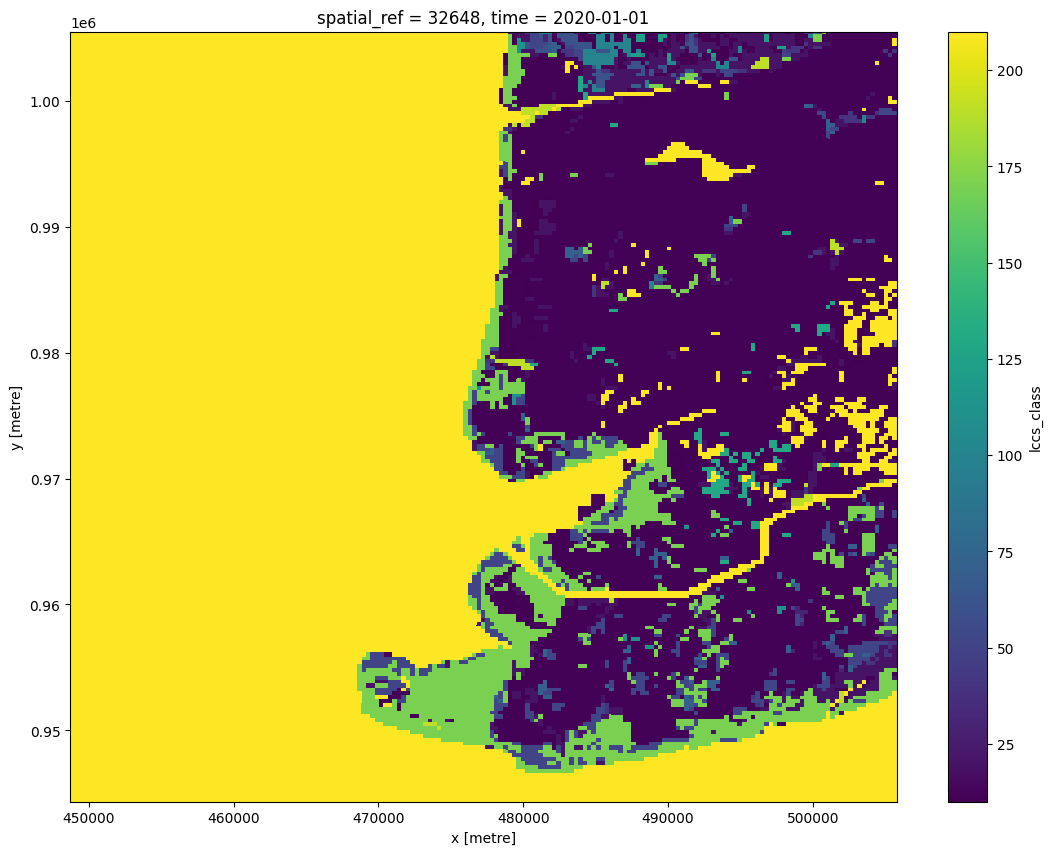

In [48]:
landcover.lccs_class.isel(time=0).plot(size=10)

In [88]:
# Load some data from ESA's land cover
from planetary_computer import sign

pc_url = "https://planetarycomputer.microsoft.com/api/stac/v1/"

pc_client = Client.open(pc_url)
items = sign(pc_client.search(collections=["esa-cci-lc"], bbox=bbox, datetime="2005/2022").get_all_items())
print(len(items))

# landcover = load(sign(items), bbox=bbox, chunks={}, crs=most_common_epsg, resolution=30)
# landcover

# # Create a binary mask for water
# ocean = mask_cleanup(landcover.lccs_class == 210, [("erosion", 50)])
# ocean.plot()


16


In [91]:
for item in items:
  print(item)

<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1-N00E090>
<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2019-v2.1.1-N00E090>
<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1-N00E090>
<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2017-v2.1.1-N00E090>
<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2016-v2.1.1-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2014-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2012-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2011-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2010-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2009-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2008-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2007-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2006-v2.0.7cds-N00E090>
<Item id=ESACCI-LC-L4-LCCS-Map-300m-P1Y-2005-v2.0.7cds-N00E090>


In [86]:
bb = ds.odc.geobox.crs
bbox = [bb.left, bb.bottom, bb.right, bb.top]
bbox

[104.53324384045173, 8.54282692160201, 105.05278253489186, 9.096125547468988]

In [93]:
ds.odc.geobox.crs.epsg

32648

In [ ]:
ds.year

### Close Dask client

In [11]:
dask_client.close()